<a href="https://colab.research.google.com/github/manypeople-AI/-/blob/main/miniproject_lgbm_best%20score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
import category_encoders as ce
import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preparing & Preprocessing Dataset

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd /content/gdrive/My Drive/mini_project

/content/gdrive/My Drive/mini_project


In [5]:
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
categ = pd.read_csv("item_categories.csv")
train = pd.read_csv("sales_train.csv")
test= pd.read_csv("test.csv").set_index('ID')

train data 결측치/이상치/중복행 제거

In [6]:
#train data 결측치 확인

train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

-> 결측치는 없음

In [7]:
#train/test data 중복 여부 확인
sum(train.duplicated()), sum(test.duplicated())

(6, 0)

-> train data에 중복행이 6개 존재

In [8]:
#item, category, shops 중복 여부 확인
sum(items.duplicated()),sum(categ.duplicated()),sum(shops.duplicated())

(0, 0, 0)

In [9]:
#train data 중복행 제거해주기
train.drop_duplicates(inplace=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


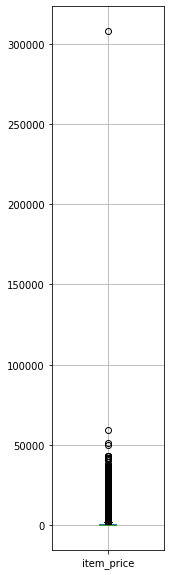

In [11]:
#이상치 처리
import seaborn as sns
import matplotlib.pyplot as plt

#상자그림으로 확인해보기 - item price
plt.figure(figsize=(2,10))
train.boxplot(column =['item_price'])
plt.show()

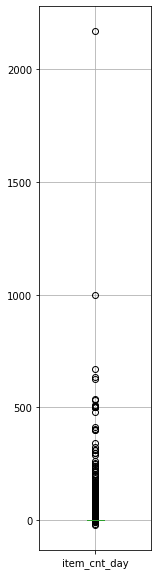

In [12]:
#상자그림 -  item_cnt_day(하루에 해당 item이 팔린 갯수)
plt.figure(figsize=(2,10))
train.boxplot(column=['item_cnt_day'])
plt.show()

In [13]:
#이상치 제거
train = train[train.item_price<=100000]
train = train[train.item_cnt_day<=1002]
train = train[train.item_price>=0]
train = train[train.item_cnt_day>=0]

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928484 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.4+ MB


category data

In [15]:
categ.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
pd.DataFrame(categ.item_category_name.values.reshape(-1,4))

,0,1,2,3
0,PC - Гарнитуры/Наушники,Аксессуары - PS2,Аксессуары - PS3,Аксессуары - PS4
1,Аксессуары - PSP,Аксессуары - PSVita,Аксессуары - XBOX 360,Аксессуары - XBOX ONE
2,Билеты (Цифра),Доставка товара,Игровые консоли - PS2,Игровые консоли - PS3
3,Игровые консоли - PS4,Игровые консоли - PSP,Игровые консоли - PSVita,Игровые консоли - XBOX 360
4,Игровые консоли - XBOX ONE,Игровые консоли - Прочие,Игры - PS2,Игры - PS3
5,Игры - PS4,Игры - PSP,Игры - PSVita,Игры - XBOX 360
6,Игры - XBOX ONE,Игры - Аксессуары для игр,Игры Android - Цифра,Игры MAC - Цифра
7,Игры PC - Дополнительные издания,Игры PC - Коллекционные издания,Игры PC - Стандартные издания,Игры PC - Цифра
8,"Карты оплаты (Кино, Музыка, Игры)",Карты оплаты - Live!,Карты оплаты - Live! (Цифра),Карты оплаты - PSN
9,Карты оплаты - Windows (Цифра),Кино - Blu-Ray,Кино - Blu-Ray 3D,Кино - Blu-Ray 4K


In [17]:
# 모든 카테고리 이름들에 기본과 하위 사이에 '-'가 있는 것은 X
# 문자가 아닌 것들의 바로 앞 이름을 추출해 그룹을 생성하고 그룹이름을 인코딩하는 레이블로 group_id 열을 생성


#pandas에서 문자열 관련 함수를 사용, 전처리하기 위해서는 명령어 앞에 str을 붙인다
#extract() : 원하는 문자열 추출, 정규표현식 이용
categ['group_name'] = categ['item_category_name'].str.extract(r'(^[\w\s]*)')

#strip() : 공백제거
categ['group_name'] = categ['group_name'].str.strip()

#label encoding 하기
categ['type_id']=le.fit_transform(categ.group_name.values)

categ.head(5)

,item_category_name,item_category_id,group_name,type_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1


In [18]:
categ=categ[['item_category_id','type_id']]
categ.head(3)

,item_category_id,type_id
0,0,0
1,1,1
2,2,1


item data

In [19]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [20]:
#item_name clean

#소문자로 바꾸기
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.','')

#정규표현식, 제거?
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')


items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')

In [21]:
#extract first n characters of name
items['item_name_no_space'] = items['item_name'].str.replace(' ', '')
items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]
items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]
del items['item_name_no_space']


In [22]:
#label encode 
items.item_name_first4 = le.fit_transform(items.item_name_first4.values)
items.item_name_first6 = le.fit_transform(items.item_name_first6.values)
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)

In [23]:
#join category_name, group_name and group_id to items
items = items.join(categ.set_index('item_category_id'), on='item_category_id')
items.sample(10)

,item_name,item_id,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id
12764,копы юбках bd,12764,37,2245,3481,6078,10
8733,безумный макс полный апокалипсис регион,8733,40,1392,2078,3663,10
21341,хворостовский дмитрий романсы,21341,55,3662,5668,9929,12
9795,великий уравнитель регион,9795,40,1574,2390,4229,10
21363,хоббит трилогия real 3d bd bd,21363,41,3675,5682,9955,10
1731,bocelli andrea cieldi di toscana,1731,55,220,301,524,12
10634,головоломка двойное cast,10634,67,1745,2645,4595,13
9697,ввс планета земля 4bd,9697,37,1562,2359,4177,10
314,1с аудиокниги марк твен принц нищий jewel,314,45,33,38,52,11
14983,маска dota juggernaut,14983,61,2456,3815,6741,13


item data에서 중복행 제거

In [24]:
dupes = items[(items.duplicated(subset=['item_name','item_category_id'],keep=False))]
dupes

,item_name,item_id,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id
32,,32,40,0,0,0,10
126,1с аудиокниги сказки выпуск цифровая версия,126,44,33,38,52,11
127,1с аудиокниги сказки выпуск цифровая версия,127,44,33,38,52,11
128,1с аудиокниги сказки выпуск цифровая версия,128,44,33,38,52,11
129,1с аудиокниги сказки выпуск цифровая версия,129,44,33,38,52,11
...,...,...,...,...,...,...,...
22036,элвин бурундуки bd,22036,37,3832,5920,10302,10
22038,элвин бурундуки,22038,40,3832,5920,10302,10
22039,элвин бурундуки bd,22039,37,3832,5920,10302,10
22111,юмор сатира рассказы русских писателей ...,22111,43,3855,5947,10336,11


In [25]:
#isin() : series나 dataframe 안에 요소가 isin()메서드에 입력된 데이터에 있는지 판별해줌
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
dupes = dupes.groupby('item_name').agg({'item_id':['first','last'],'in_test':['first','last']})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
#if both item id's are in the test set do nothing
dupes = dupes[(dupes[('in_test', 'first')]==False) | (dupes[('in_test', 'last')]==False)]
#if only the first id is in the test set assign this id to both
temp = dupes[dupes[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))
#if neither id or only the second id is in the test set, assign the second id to both
temp = dupes[dupes[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}

sales data

In [27]:
sales = (train
    .query('0 < item_price < 50000 and 0 < item_cnt_day < 1001') #removing outliers
    .replace({
        'shop_id':{0:57, 1:58, 11:10}, #replacing obsolete shop id's
        'item_id':item_map #fixing duplicate item id's  
    })    
)

#removing shops which don't appear in the test set
sales = sales[sales['shop_id'].isin(test.shop_id.unique())]

sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')
sales['weekday'] = sales.date.dt.dayofweek

#first day the item was sold, day 0 is the first day of the training set period
sales['first_sale_day'] = sales.date.dt.dayofyear 
sales['first_sale_day'] += 365 * (sales.date.dt.year-2013)
sales['first_sale_day'] = sales.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

#revenue is needed to accurately calculate prices after grouping
sales['revenue'] = sales['item_cnt_day']*sales['item_price']

In [28]:
temp = sales.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, sales.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on='shop_id', how='left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales']/temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum','first_day_of_month':'min'}).reset_index()

dates.query('shop_id == 28').head(15)

,date_block_num,shop_id,month,year,day_quality,first_day_of_month
18,0,28,1,0,4.300037,1
60,1,28,2,0,4.000000,32
102,2,28,3,0,4.605952,60
144,3,28,4,0,4.193211,91
186,4,28,5,0,4.333970,121
228,5,28,6,0,4.472819,152
270,6,28,7,0,4.287644,182
312,7,28,8,0,4.492718,213
354,8,28,9,0,4.313648,244
396,9,28,10,0,4.300037,274


In [29]:
sales = (sales
     .groupby(['date_block_num', 'shop_id', 'item_id'])
     .agg({
         'item_cnt_day':'sum', 
         'revenue':'sum',
         'first_sale_day':'first'
     })
     .reset_index()
     .rename(columns={'item_cnt_day':'item_cnt'})
)
sales.sample(5)

,date_block_num,shop_id,item_id,item_cnt,revenue,first_sale_day
561605,12,26,4571,1.0,299.0,95
849455,19,58,11684,1.0,199.0,564
26694,0,35,2307,1.0,2798.5,1
510046,11,25,5235,18.0,17581.5,323
1251303,31,35,8452,3.0,7570.0,634


constructing training dataframe

In [30]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,2,27,0
1,2,33,0
2,2,317,0
3,2,438,0
4,2,473,0


In [31]:
test.columns

Index(['shop_id', 'item_id'], dtype='object')

In [32]:
#add the appropriate date_block_num value to the test set
test['date_block_num'] = 34

#append test set to training dataframe
df = pd.concat([df,test]).fillna(0)
df = df.reset_index()
del df['index']

In [33]:
items.head(3)

,item_name,item_id,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id
0,во власти наваждения пласт,0,40,1623,2463,4332,10
1,abbyy finereader 12 professional edition full...,1,76,105,130,211,14
2,лучах славы unv,2,40,2409,3707,6553,10


In [34]:
#join sales and item inforamtion to the training dataframe
df = pd.merge(df, sales, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
df = pd.merge(df, dates, on=['date_block_num','shop_id'], how='left')
df = pd.merge(df, items.drop(columns=['item_name']), on='item_id', how='left')

adding shop information

In [35]:
df

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,1,1,1,5
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,187,249,414,10
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,33,38,52,11
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,33,38,54,11
4,2,473,0,2.0,798.0,3.0,1,0,4.381749,1,49,35,43,59,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756434,45,18454,34,0.0,0.0,0.0,11,2,4.288065,1035,55,3230,5005,8681,12
8756435,45,16188,34,0.0,0.0,0.0,11,2,4.288065,1035,64,2622,4079,7191,13
8756436,45,15757,34,0.0,0.0,0.0,11,2,4.288065,1035,55,2693,4180,7335,12
8756437,45,19648,34,0.0,0.0,0.0,11,2,4.288065,1035,40,3465,5407,9365,10


In [36]:
#clustering shops
shops_cats = pd.DataFrame(
    np.array(list(product(*[df['shop_id'].unique(), df['item_category_id'].unique()]))),
    columns =['shop_id', 'item_category_id']
)
temp = df.groupby(['item_category_id', 'shop_id']).agg({'item_cnt':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt':'sum'}).rename(columns={'item_cnt':'shop_total'})
temp = temp.join(temp2, on='shop_id')
temp['category_proportion'] = temp['item_cnt']/temp['shop_total']
temp = temp[['shop_id', 'item_category_id', 'category_proportion']]
shops_cats = pd.merge(shops_cats, temp, on=['shop_id','item_category_id'], how='left')
shops_cats = shops_cats.fillna(0)

shops_cats = shops_cats.pivot(index='shop_id', columns=['item_category_id'])
kmeans = KMeans(n_clusters=7, random_state=0).fit(shops_cats)
shops_cats['shop_cluster'] = kmeans.labels_.astype('int8')

#adding these clusters to the shops dataframe
shops = shops.join(shops_cats['shop_cluster'], on='shop_id')

In [37]:
#removing unused shop ids
shops.dropna(inplace=True)

#cleaning the name column
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

#creating a column for the type of shop
shops['shop_type'] = 'regular'

#there is some overlap in tc and mall, mall is given precedence
shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'

#the first word of shop name is largely sufficient as a city feature
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'
shops.shop_city = le.fit_transform(shops.shop_city.values)
shops.shop_type = le.fit_transform(shops.shop_type.values)
shops.head()

,shop_name,shop_id,shop_cluster,shop_type,shop_city
2,адыгея тц мега,2,4.0,1,1
3,балашиха трк октябрь киномир,3,0.0,1,2
4,волжский тц волга молл,4,0.0,1,3
5,вологда трц мармелад,5,0.0,1,4
6,воронеж плехановская 13,6,0.0,1,5


In [38]:
df = pd.merge(df, shops.drop(columns='shop_name'), on='shop_id', how='left')
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id,shop_cluster,shop_type,shop_city
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,1,1,1,5,4.0,1,1
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,187,249,414,10,4.0,1,1
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,33,38,52,11,4.0,1,1
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,33,38,54,11,4.0,1,1
4,2,473,0,2.0,798.0,3.0,1,0,4.381749,1,49,35,43,59,11,4.0,1,1


Ages & Aggregating sales/price information

In [39]:
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('max').astype('int16')
df.loc[df['first_sale_day']==0, 'first_sale_day'] = 1035
df['prev_days_on_sale'] = [max(idx) for idx in zip(df['first_day_of_month']-df['first_sale_day'],[0]*len(df))]
del df['first_day_of_month']

In [40]:
#freeing RAM, removing unneeded columns and encoding object columns
del sales, categ, shops, shops_cats, temp, temp2, test, dupes, item_map, 
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,item_category_id,item_name_first4,item_name_first6,item_name_first11,type_id,shop_cluster,shop_type,shop_city,prev_days_on_sale
0,2,27,0,1.0,2499.0,2,1,0,4.381749,19,1,1,1,5,4.0,1,1,0
1,2,33,0,1.0,499.0,2,1,0,4.381749,37,187,249,414,10,4.0,1,1,0
2,2,317,0,1.0,299.0,4,1,0,4.381749,45,33,38,52,11,4.0,1,1,0
3,2,438,0,1.0,299.0,19,1,0,4.381749,45,33,38,54,11,4.0,1,1,0
4,2,473,0,2.0,798.0,3,1,0,4.381749,49,35,43,59,11,4.0,1,1,0


In [41]:
df['item_cnt_unclipped'] = df['item_cnt']
df['item_cnt'] = df['item_cnt'].clip(0, 20)

In [42]:
def downcast(df):
    #reduce size of the dataframe
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df
df = downcast(df)

In [43]:
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')
df['item_name_first4_age'] = (df['date_block_num'] - df.groupby('item_name_first4')['date_block_num'].transform('min')).astype('int8')
df['item_name_first6_age'] = (df['date_block_num'] - df.groupby('item_name_first6')['date_block_num'].transform('min')).astype('int8')
df['item_name_first11_age'] = (df['date_block_num'] - df.groupby('item_name_first11')['date_block_num'].transform('min')).astype('int8')
df['category_age'] = (df['date_block_num'] - df.groupby('item_category_id')['date_block_num'].transform('min')).astype('int8')
df['group_age'] = (df['date_block_num'] - df.groupby('type_id')['date_block_num'].transform('min')).astype('int8')
df['shop_age'] = (df['date_block_num'] - df.groupby('shop_id')['date_block_num'].transform('min')).astype('int8')

In [44]:
#indicates whether shops have previously sold the item
temp = df.query('item_cnt > 0').groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()
temp.columns = ['item_id', 'shop_id', 'item_shop_first_sale']
df = pd.merge(df, temp, on=['item_id','shop_id'], how='left')
df['item_shop_first_sale'] = df['item_shop_first_sale'].fillna(50)
#item age that stays at 0 if a shop hasn't sold the item
df['item_age_if_shop_sale'] = (df['date_block_num'] > df['item_shop_first_sale']) * df['item_age']
#the length of time an item has been for sale without being sold at individual shops
df['item_age_without_shop_sale'] = (df['date_block_num'] <= df['item_shop_first_sale']) * df['item_age']
del df['item_shop_first_sale']

In [45]:
def agg_cnt_col(df, merging_cols, new_col,aggregation):
    temp = df.groupby(merging_cols).agg(aggregation).reset_index()
    temp.columns = merging_cols + [new_col]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#individual items across all shops
df = agg_cnt_col(df, ['date_block_num','item_id'],'item_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'item_cnt_all_shops_median',{'item_cnt':'median'}) 
#all items in category at individual shops
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'category_cnt',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'category_cnt_median',{'item_cnt':'median'}) 
#all items in category across all shops
df = agg_cnt_col(df, ['date_block_num','item_category_id'],'category_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id'],'category_cnt_all_shops_median',{'item_cnt':'median'})
#all items in group
df = agg_cnt_col(df, ['date_block_num','type_id','shop_id'],'group_cnt',{'item_cnt':'mean'})
#all items in group across all shops
df = agg_cnt_col(df, ['date_block_num','type_id'],'group_cnt_all_shops',{'item_cnt':'mean'})
#all items at individual shops
df = agg_cnt_col(df, ['date_block_num','shop_id'],'shop_cnt',{'item_cnt':'mean'})
#all items at all shops within the city
df = agg_cnt_col(df, ['date_block_num','shop_city'],'city_cnt',{'item_cnt':'mean'})

In [46]:
def new_item_sales(df, merging_cols, new_col):
    temp = (
        df
        .query('item_age==0')
        .groupby(merging_cols)['item_cnt']
        .mean()
        .reset_index()
        .rename(columns={'item_cnt': new_col})
    )
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#mean units sold of new item in category at individual shop
df = new_item_sales(df, ['date_block_num','item_category_id','shop_id'], 'new_items_in_cat')
#mean units sold of new item in category across all shops
df = new_item_sales(df, ['date_block_num','item_category_id'], 'new_items_in_cat_all_shops')

In [47]:
def agg_price_col(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'revenue':'sum','item_cnt_unclipped':'sum'}).reset_index()
    temp[new_col] = temp['revenue']/temp['item_cnt_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#average item price
df = agg_price_col(df,['date_block_num','item_id'],'item_price')
#average price of items in category
df = agg_price_col(df,['date_block_num','item_category_id'],'category_price')
#average price of all items
df = agg_price_col(df,['date_block_num'],'block_price')

In [48]:
df = downcast(df)

Lagging values & features that use prior information

In [49]:
def lag_feature(df, lag, col, merge_cols):        
    temp = df[merge_cols + [col]]
    temp = temp.groupby(merge_cols).agg({f'{col}':'first'}).reset_index()
    temp.columns = merge_cols + [f'{col}_lag{lag}']
    temp['date_block_num'] += lag
    df = pd.merge(df, temp, on=merge_cols, how='left')
    df[f'{col}_lag{lag}'] = df[f'{col}_lag{lag}'].fillna(0).astype('float32')
    return df

In [50]:
lag12_cols = {
    'item_cnt':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops':['date_block_num', 'item_id'],
    'category_cnt':['date_block_num', 'shop_id', 'item_category_id'],
    'category_cnt_all_shops':['date_block_num', 'item_category_id'],
    'group_cnt':['date_block_num', 'shop_id', 'type_id'],
    'group_cnt_all_shops':['date_block_num', 'type_id'],
    'shop_cnt':['date_block_num', 'shop_id'],
    'city_cnt':['date_block_num', 'shop_city'],
    'new_items_in_cat':['date_block_num', 'shop_id', 'item_category_id'],
    'new_items_in_cat_all_shops':['date_block_num', 'item_category_id']
}
for col,merge_cols in lag12_cols.items():
    df[f'{col}_lag1to12'] = 0
    for i in range(1,13):
        df = lag_feature(df, i, col, merge_cols)
        df[f'{col}_lag1to12'] += df[f'{col}_lag{i}']
        if i > 2:
            del df[f'{col}_lag{i}']
    if col == 'item_cnt':
        del df[f'{col}_lag1']
        del df[f'{col}_lag2']        
    else:
        del df[col]

In [51]:
lag2_cols = {
    'item_cnt_unclipped':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops_median':['date_block_num', 'item_id'],
    'category_cnt_median':['date_block_num', 'shop_id', 'category_id'],
    'category_cnt_all_shops_median':['date_block_num', 'category_id']
}
for col in lag2_cols:
    df = lag_feature(df, 1, col, merge_cols)
    df = lag_feature(df, 2, col, merge_cols)
    if col!='item_cnt_unclipped':
        del df[col]

In [52]:
df['item_cnt_diff'] = df['item_cnt_unclipped_lag1']/df['item_cnt_lag1to12']
df['item_cnt_all_shops_diff'] = df['item_cnt_all_shops_lag1']/df['item_cnt_all_shops_lag1to12']
df['category_cnt_diff'] = df['category_cnt_lag1']/df['category_cnt_lag1to12']
df['category_cnt_all_shops_diff'] = df['category_cnt_all_shops_lag1']/df['category_cnt_all_shops_lag1to12']

In [53]:
df = lag_feature(df, 1, 'category_price',['date_block_num', 'item_category_id'])
df = lag_feature(df, 1, 'block_price',['date_block_num'])
del df['category_price'], df['block_price']

In [54]:
df.loc[(df['item_age']>0) & (df['item_cnt_lag1to12'].isna()), 'item_cnt_lag1to12'] = 0
df.loc[(df['category_age']>0) & (df['category_cnt_lag1to12'].isna()), 'category_cnt_lag1to12'] = 0
df.loc[(df['group_age']>0) & (df['group_cnt_lag1to12'].isna()), 'group_cnt_lag1to12'] = 0

In [55]:
df['item_cnt_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],df['shop_age'],[12]*len(df))]
df['item_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],[12]*len(df))]
df['category_cnt_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['category_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]
df['group_cnt_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],df['shop_age'],[12]*len(df))]
df['group_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],[12]*len(df))]
df['city_cnt_lag1to12'] /= [min(idx) for idx in zip(df['date_block_num'],[12]*len(df))]
df['shop_cnt_lag1to12'] /= [min(idx) for idx in zip(df['shop_age'],[12]*len(df))]
df['new_items_in_cat_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['new_items_in_cat_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]

In [56]:
df = downcast(df)

In [57]:
def past_information(df, merging_cols, new_col, aggregation):
    temp = []
    for i in range(1,35):
        block = df.query(f'date_block_num < {i}').groupby(merging_cols).agg(aggregation).reset_index()
        block.columns = merging_cols + [new_col]
        block['date_block_num'] = i
        block = block[block[new_col]>0]
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=['date_block_num']+merging_cols, how='left')
    return df

#average item price in latest block item was sold
df = past_information(df, ['item_id'],'last_item_price',{'item_price':'last'})
#total units of item sold at individual shop
df = past_information(df, ['shop_id','item_id'],'item_cnt_sum_alltime',{'item_cnt':'sum'})
#total units of item sold at all shops
df = past_information(df, ['item_id'],'item_cnt_sum_alltime_allshops',{'item_cnt':'sum'})

#these columns are no longer needed, and would cause data leakage if retained
del df['revenue'], df['item_cnt_unclipped'], df['item_price']

In [58]:
df['relative_price_item_block_lag1'] = df['last_item_price']/df['block_price_lag1']

In [59]:
df['item_cnt_per_day_alltime'] = (df['item_cnt_sum_alltime']/df['prev_days_on_sale']).fillna(0)
df['item_cnt_per_day_alltime_allshops'] = (df['item_cnt_sum_alltime_allshops']/df['prev_days_on_sale']).fillna(0)

In [60]:
import gc
gc.collect()
df = downcast(df)

In [61]:
def matching_name_cat_age(df,n,all_shops):
    temp_cols = [f'same_name{n}catage_cnt','date_block_num', f'item_name_first{n}','item_age','item_category_id']
    if all_shops:
        temp_cols[0] += '_all_shops'
    else:
        temp_cols += ['shop_id']
    temp = []
    for i in range(1,35):
        block = (
            df
            .query(f'date_block_num < {i}')
            .groupby(temp_cols[2:])
            .agg({'item_cnt':'mean'})
            .reset_index()
            .rename(columns={'item_cnt':temp_cols[0]})
        )
        block = block[block[temp_cols[0]]>0]
        block['date_block_num'] = i
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=temp_cols[1:], how='left')
    return df

for n in [4,6,11]:
    for all_shops in [True,False]:
        df = matching_name_cat_age(df,n,all_shops)

In [62]:
#assign appropriate datatypes
df = downcast(df)
int8_cols = [
    'item_cnt','month','type_id','shop_type',
    'shop_city','shop_id','date_block_num','item_category_id',
    'item_age',
]
int16_cols = [
    'item_id','item_name_first4',
    'item_name_first6','item_name_first11'
]
for col in int8_cols:
    df[col] = df[col].astype('int8')
for col in int16_cols:
    df[col] = df[col].astype('int16')

In [63]:
def nearby_item_data(df,col):
    if col in ['item_cnt_unclipped_lag1','item_cnt_lag1to12']:
        cols = ['date_block_num', 'shop_id', 'item_id']
        temp = df[cols + [col]] 
    else:
        cols = ['date_block_num', 'item_id']
        temp = df.groupby(cols).agg({col:'first'}).reset_index()[cols + [col]]   
    
    temp.columns = cols + [f'below_{col}']
    temp['item_id'] += 1
    df = pd.merge(df, temp, on=cols, how='left')
    
    temp.columns = cols + [f'above_{col}']
    temp['item_id'] -= 2
    df = pd.merge(df, temp, on=cols, how='left')
    
    return df

item_cols = ['item_cnt_unclipped_lag1','item_cnt_lag1to12',
             'item_cnt_all_shops_lag1','item_cnt_all_shops_lag1to12']
for col in item_cols:
    df = nearby_item_data(df,col)
    
del temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


encoding name information

In [64]:
results = Counter()
items['item_name'].str.split().apply(results.update)

words = []
cnts = []
for key, value in results.items():
    words.append(key)
    cnts.append(value)
    
counts = pd.DataFrame({'word':words,'count':cnts})
common_words = counts.query('count>200').word.to_list()
for word in common_words:
    items[f'{word}_in_name'] = items['item_name'].str.contains(word).astype('int8')
drop_cols = [
    'item_id','item_category_id','item_name','item_name_first4',
    'item_name_first6','item_name_first11',
    'type_id'
]
items = items.drop(columns=drop_cols)

In [65]:
df = df.join(items, on='item_id')

In [66]:
def binary_encode(df, letters, cols):
    encoder = ce.BinaryEncoder(cols=[f'item_name_first{letters}'], return_df=True)
    temp = encoder.fit_transform(df[f'item_name_first{letters}'])
    df = pd.concat([df,temp], axis=1)
    del df[f'item_name_first{letters}_0']
    name_cols = [f'item_name_first{letters}_{x}' for x in range(1,cols)]
    df[name_cols] = df[name_cols].astype('int8')
    return df

df = binary_encode(df, 11, 15)
    
del df['item_name_first4'], df['item_name_first6']

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [67]:
#save dataframe for later use
df.to_pickle('df_complete.pkl')
#Reset the kernel to clear memory.
%reset -f

# Modeling

In [68]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 30)

import warnings
warnings.filterwarnings("ignore")

In [69]:
#load the saved training dataframe
df = pd.read_pickle('df_complete.pkl')

X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_cnt']
del X_train['item_cnt']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_cnt']
del X_val['item_cnt']

X_test = df[df['date_block_num']==34].drop(columns='item_cnt')
X_test = X_test.reset_index()
del X_test['index']

#free memory
del df

In [70]:
!pip install optuna

In [71]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [72]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [73]:
def objective(trial):

    # choose parameters that you want
    
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.train(param, 
                      lgb_train,
                      valid_sets=[lgb_train,lgb_eval],
                      early_stopping_rounds=15, #10,
                      verbose_eval=1)
    
    y_pred = model.predict(X_val)
    accuracy = mean_squared_error(y_val, y_pred,squared=False)

    return accuracy

In [75]:
from sklearn.metrics import mean_squared_error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-03-09 18:07:49,214] A new study created in memory with name: no-name-1533e947-da92-43e8-a0ff-22d900b384db


[1]	training's rmse: 1.1898	valid_1's rmse: 1.03429
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.1404	valid_1's rmse: 0.993885
[3]	training's rmse: 1.09743	valid_1's rmse: 0.962671
[4]	training's rmse: 1.05946	valid_1's rmse: 0.930012
[5]	training's rmse: 1.02698	valid_1's rmse: 0.903287
[6]	training's rmse: 0.998309	valid_1's rmse: 0.88061
[7]	training's rmse: 0.976497	valid_1's rmse: 0.863158
[8]	training's rmse: 0.95525	valid_1's rmse: 0.847942
[9]	training's rmse: 0.936493	valid_1's rmse: 0.833127
[10]	training's rmse: 0.919897	valid_1's rmse: 0.823302
[11]	training's rmse: 0.905066	valid_1's rmse: 0.815077
[12]	training's rmse: 0.893006	valid_1's rmse: 0.806743
[13]	training's rmse: 0.882548	valid_1's rmse: 0.798965
[14]	training's rmse: 0.872787	valid_1's rmse: 0.793161
[15]	training's rmse: 0.864673	valid_1's rmse: 0.786518
[16]	training's rmse: 0.856852	valid_1's rmse: 0.782238
[17]	training's rmse: 0.850065	valid_1's rmse: 0.77902
[18]	t

[I 2021-03-09 18:09:12,483] Trial 0 finished with value: 0.755631118720165 and parameters: {'lambda_l1': 2.6251110956893468e-08, 'lambda_l2': 3.6301168455245703e-06, 'num_leaves': 151, 'feature_fraction': 0.5789235227080344, 'bagging_fraction': 0.7184556777661023, 'bagging_freq': 3, 'min_child_samples': 96}. Best is trial 0 with value: 0.755631118720165.


[1]	training's rmse: 1.19797	valid_1's rmse: 1.03774
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.15508	valid_1's rmse: 0.999101
[3]	training's rmse: 1.11946	valid_1's rmse: 0.967511
[4]	training's rmse: 1.08779	valid_1's rmse: 0.939559
[5]	training's rmse: 1.0605	valid_1's rmse: 0.915354
[6]	training's rmse: 1.03682	valid_1's rmse: 0.893406
[7]	training's rmse: 1.01679	valid_1's rmse: 0.878355
[8]	training's rmse: 0.999914	valid_1's rmse: 0.864077
[9]	training's rmse: 0.98516	valid_1's rmse: 0.852678
[10]	training's rmse: 0.973026	valid_1's rmse: 0.842819
[11]	training's rmse: 0.962549	valid_1's rmse: 0.834738
[12]	training's rmse: 0.952634	valid_1's rmse: 0.825554
[13]	training's rmse: 0.943279	valid_1's rmse: 0.819276
[14]	training's rmse: 0.935239	valid_1's rmse: 0.813823
[15]	training's rmse: 0.928362	valid_1's rmse: 0.809517
[16]	training's rmse: 0.921893	valid_1's rmse: 0.805814
[17]	training's rmse: 0.91632	valid_1's rmse: 0.801742
[18]	t

[I 2021-03-09 18:10:56,136] Trial 1 finished with value: 0.755547139266804 and parameters: {'lambda_l1': 7.839629713067307e-06, 'lambda_l2': 0.001972648618422759, 'num_leaves': 28, 'feature_fraction': 0.8675640553279816, 'bagging_fraction': 0.7433995835009533, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 1 with value: 0.755547139266804.


[1]	training's rmse: 1.19366	valid_1's rmse: 1.03537
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14845	valid_1's rmse: 0.99443
[3]	training's rmse: 1.10823	valid_1's rmse: 0.962124
[4]	training's rmse: 1.07369	valid_1's rmse: 0.930538
[5]	training's rmse: 1.04339	valid_1's rmse: 0.905385
[6]	training's rmse: 1.01793	valid_1's rmse: 0.882935
[7]	training's rmse: 0.997882	valid_1's rmse: 0.86741
[8]	training's rmse: 0.978831	valid_1's rmse: 0.852967
[9]	training's rmse: 0.962128	valid_1's rmse: 0.841078
[10]	training's rmse: 0.946789	valid_1's rmse: 0.832099
[11]	training's rmse: 0.933875	valid_1's rmse: 0.822616
[12]	training's rmse: 0.922166	valid_1's rmse: 0.814689
[13]	training's rmse: 0.9127	valid_1's rmse: 0.806932
[14]	training's rmse: 0.90366	valid_1's rmse: 0.801038
[15]	training's rmse: 0.895801	valid_1's rmse: 0.795073
[16]	training's rmse: 0.888793	valid_1's rmse: 0.79099
[17]	training's rmse: 0.881839	valid_1's rmse: 0.787322
[18]	tra

[I 2021-03-09 18:12:25,584] Trial 2 finished with value: 0.7455493908480426 and parameters: {'lambda_l1': 0.46635320365294364, 'lambda_l2': 5.044542976160322e-06, 'num_leaves': 63, 'feature_fraction': 0.6910346500368354, 'bagging_fraction': 0.5867866139707472, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 2 with value: 0.7455493908480426.


[1]	training's rmse: 1.19092	valid_1's rmse: 1.03533
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14247	valid_1's rmse: 0.996251
[3]	training's rmse: 1.09983	valid_1's rmse: 0.962638
[4]	training's rmse: 1.06283	valid_1's rmse: 0.931371
[5]	training's rmse: 1.03128	valid_1's rmse: 0.904706
[6]	training's rmse: 1.00345	valid_1's rmse: 0.886544
[7]	training's rmse: 0.982369	valid_1's rmse: 0.868879
[8]	training's rmse: 0.961243	valid_1's rmse: 0.854034
[9]	training's rmse: 0.942913	valid_1's rmse: 0.839858
[10]	training's rmse: 0.926162	valid_1's rmse: 0.829046
[11]	training's rmse: 0.911814	valid_1's rmse: 0.820792
[12]	training's rmse: 0.899575	valid_1's rmse: 0.812547
[13]	training's rmse: 0.889206	valid_1's rmse: 0.804211
[14]	training's rmse: 0.879438	valid_1's rmse: 0.799418
[15]	training's rmse: 0.872059	valid_1's rmse: 0.794819
[16]	training's rmse: 0.863861	valid_1's rmse: 0.790252
[17]	training's rmse: 0.857094	valid_1's rmse: 0.786412
[1

[I 2021-03-09 18:14:08,403] Trial 3 finished with value: 0.7529375971294733 and parameters: {'lambda_l1': 0.0033782860584436964, 'lambda_l2': 1.7401699559340357e-07, 'num_leaves': 119, 'feature_fraction': 0.5462183519166149, 'bagging_fraction': 0.9364540364136891, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 2 with value: 0.7455493908480426.


[1]	training's rmse: 1.18947	valid_1's rmse: 1.032
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.14045	valid_1's rmse: 0.990232
[3]	training's rmse: 1.09724	valid_1's rmse: 0.955996
[4]	training's rmse: 1.05971	valid_1's rmse: 0.92788
[5]	training's rmse: 1.02713	valid_1's rmse: 0.903829
[6]	training's rmse: 0.99953	valid_1's rmse: 0.878292
[7]	training's rmse: 0.975328	valid_1's rmse: 0.859507
[8]	training's rmse: 0.954826	valid_1's rmse: 0.845307
[9]	training's rmse: 0.936596	valid_1's rmse: 0.832069
[10]	training's rmse: 0.921145	valid_1's rmse: 0.820749
[11]	training's rmse: 0.907894	valid_1's rmse: 0.80854
[12]	training's rmse: 0.89576	valid_1's rmse: 0.802255
[13]	training's rmse: 0.885453	valid_1's rmse: 0.796535
[14]	training's rmse: 0.875469	valid_1's rmse: 0.790799
[15]	training's rmse: 0.867302	valid_1's rmse: 0.785226
[16]	training's rmse: 0.859847	valid_1's rmse: 0.781398
[17]	training's rmse: 0.852852	valid_1's rmse: 0.776216
[18]	tr

[I 2021-03-09 18:16:11,656] Trial 4 finished with value: 0.7446317705982545 and parameters: {'lambda_l1': 0.04371319094958546, 'lambda_l2': 0.00011963621659485764, 'num_leaves': 131, 'feature_fraction': 0.9200627131285918, 'bagging_fraction': 0.5973665006710144, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 4 with value: 0.7446317705982545.


Number of finished trials: 5
Best trial: {'lambda_l1': 0.04371319094958546, 'lambda_l2': 0.00011963621659485764, 'num_leaves': 131, 'feature_fraction': 0.9200627131285918, 'bagging_fraction': 0.5973665006710144, 'bagging_freq': 6, 'min_child_samples': 82}


In [76]:
best_params = study.best_trial.params
print(f'Best trial parameters\n{best_params}')

Best trial parameters
{'lambda_l1': 0.04371319094958546, 'lambda_l2': 0.00011963621659485764, 'num_leaves': 131, 'feature_fraction': 0.9200627131285918, 'bagging_fraction': 0.5973665006710144, 'bagging_freq': 6, 'min_child_samples': 82}


In [77]:
# add some fix params

x = {"objective": "regression",
     "metric"   : "rmse",
     "verbosity": -1,
     "boosting_type": "gbdt"}

best_params.update(x)
best_params

{'bagging_fraction': 0.5973665006710144,
 'bagging_freq': 6,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9200627131285918,
 'lambda_l1': 0.04371319094958546,
 'lambda_l2': 0.00011963621659485764,
 'metric': 'rmse',
 'min_child_samples': 82,
 'num_leaves': 131,
 'objective': 'regression',
 'verbosity': -1}

In [78]:
evals_result = {} 

model = lgb.train(best_params,
                  lgb_train,
                  valid_sets=[lgb_train,lgb_eval],

                  evals_result=evals_result,
                  early_stopping_rounds=10, # 20
                  verbose_eval=1,
                  )

[1]	training's rmse: 1.18947	valid_1's rmse: 1.032
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 1.14045	valid_1's rmse: 0.990232
[3]	training's rmse: 1.09724	valid_1's rmse: 0.955996
[4]	training's rmse: 1.05971	valid_1's rmse: 0.92788
[5]	training's rmse: 1.02713	valid_1's rmse: 0.903829
[6]	training's rmse: 0.99953	valid_1's rmse: 0.878292
[7]	training's rmse: 0.975328	valid_1's rmse: 0.859507
[8]	training's rmse: 0.954826	valid_1's rmse: 0.845307
[9]	training's rmse: 0.936596	valid_1's rmse: 0.832069
[10]	training's rmse: 0.921145	valid_1's rmse: 0.820749
[11]	training's rmse: 0.907894	valid_1's rmse: 0.80854
[12]	training's rmse: 0.89576	valid_1's rmse: 0.802255
[13]	training's rmse: 0.885453	valid_1's rmse: 0.796535
[14]	training's rmse: 0.875469	valid_1's rmse: 0.790799
[15]	training's rmse: 0.867302	valid_1's rmse: 0.785226
[16]	training's rmse: 0.859847	valid_1's rmse: 0.781398
[17]	training's rmse: 0.852852	valid_1's rmse: 0.776216
[18]	tr

In [79]:
y_pred = model.predict(X_val)
mean_squared_error(y_val, y_pred,squared=False)

0.7446317705982545

Plot metrics recorded during training...


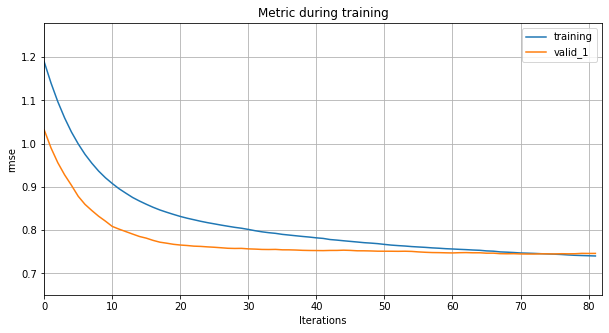

In [80]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, figsize=(10, 5))

In [81]:
test= pd.read_csv("test.csv").set_index('ID')

In [82]:
# predicting model

Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.head(10)

,ID,item_cnt_month
0,0,0.539693
1,1,1.920928
2,2,1.161255
3,3,0.759676
4,4,5.913251
5,5,0.457699
6,6,0.645941
7,7,0.207732
8,8,0.851401
9,9,0.415341


In [83]:
submission.to_csv('final2 submission.csv', index=False)